In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import os

In [3]:
import torch
import transformers
import accelerate

In [5]:
print("Torch version:", torch.__version__)

Torch version: 2.3.1+cu118


In [6]:
torch.cuda.is_available()

True

In [7]:
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

print('Training Set Shape = {}'.format(df_train.shape))
print('Training Set Memory Usage = {:.2f} MB'.format(df_train.memory_usage().sum() / 1024**2))
print('Test Set Shape = {}'.format(df_test.shape))
print('Test Set Memory Usage = {:.2f} MB'.format(df_test.memory_usage().sum() / 1024**2))

Training Set Shape = (7613, 5)
Training Set Memory Usage = 0.29 MB
Test Set Shape = (3263, 4)
Test Set Memory Usage = 0.10 MB


In [8]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [9]:
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


# Explore the dataset

In [10]:
df_train["length"] = df_train["text"].apply(lambda x : len(x))
df_test["length"] = df_test["text"].apply(lambda x : len(x))

print("Train Length Stat")
print(df_train["length"].describe())
print()

print("Test Length Stat")
print(df_test["length"].describe())

Train Length Stat
count    7613.000000
mean      101.037436
std        33.781325
min         7.000000
25%        78.000000
50%       107.000000
75%       133.000000
max       157.000000
Name: length, dtype: float64

Test Length Stat
count    3263.000000
mean      102.108183
std        33.972158
min         5.000000
25%        78.000000
50%       109.000000
75%       134.000000
max       151.000000
Name: length, dtype: float64


If you want to know more information about the data, you can grab useful information [here](https://www.kaggle.com/code/gunesevitan/nlp-with-disaster-tweets-eda-cleaning-and-bert)

Note that all the tweets are in english.

# Preprocess the data

In [12]:
BATCH_SIZE = 32
NUM_TRAINING_EXAMPLES = df_train.shape[0]
TRAIN_SPLIT = 0.8
VAL_SPLIT = 0.2
STEPS_PER_EPOCH = int(NUM_TRAINING_EXAMPLES)*TRAIN_SPLIT // BATCH_SIZE

EPOCHS = 2


In [23]:
from sklearn.model_selection import train_test_split
import sklearn

X = df_train["text"].tolist()
y = df_train["target"].tolist()

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=VAL_SPLIT, random_state=42)

X_test = df_test["text"].tolist()

In [15]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments


model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)

A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

In [16]:
train_encodings = tokenizer(X_train, truncation=True, padding=True, max_length=160)
val_encodings = tokenizer(X_val, truncation=True, padding=True, max_length=160)
test_encodings = tokenizer(X_test, truncation=True, padding=True, max_length=160)

In [17]:
class DisasterTweetsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.encodings['input_ids'])

In [18]:
train_dataset = DisasterTweetsDataset(train_encodings, y_train)
val_dataset = DisasterTweetsDataset(val_encodings, y_val)
test_dataset = DisasterTweetsDataset(test_encodings)

In [20]:
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    return {
        'accuracy': (preds == p.label_ids).mean(),
        'f1': sklearn.metrics.f1_score(p.label_ids, preds, average='weighted')
    }

In [21]:
# Define the training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch"
)

# Create a Trainer instance
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

c:\Users\georg\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [24]:
trainer.train()


 50%|█████     | 191/382 [01:42<01:42,  1.86it/s]











                                            

                                          


{'loss': 0.3799, 'grad_norm': 2.9020845890045166, 'learning_rate': 1.0000000000000002e-06, 'epoch': 0.05}


{'loss': 0.3874, 'grad_norm': 7.56204891204834, 'learning_rate': 2.0000000000000003e-06, 'epoch': 0.1}


{'loss': 0.4179, 'grad_norm': 6.59653902053833, 'learning_rate': 3e-06, 'epoch': 0.16}


{'loss': 0.3688, 'grad_norm': 6.1184306144714355, 'learning_rate': 4.000000000000001e-06, 'epoch': 0.21}


{'loss': 0.4595, 'grad_norm': 4.423591613769531, 'learning_rate': 5e-06, 'epoch': 0.26}


{'loss': 0.3466, 'grad_norm': 6.935014247894287, 'learning_rate': 6e-06, 'epoch': 0.31}


{'loss': 0.3661, 'grad_norm': 5.782161235809326, 'learning_rate': 7.000000000000001e-06, 'epoch': 0.37}


{'loss': 0.3933, 'grad_norm': 3.679486036300659, 'learning_rate': 8.000000000000001e-06, 'epoch': 0.42}


{'loss': 0.4025, 'grad_norm': 5.727291107177734, 'learning_rate': 9e-06, 'epoch': 0.47}


{'loss': 0.3459, 'grad_norm': 4.053379535675049, 'learning_rate': 1e-05, 'epoch': 0.52}


{'loss': 0.393, 'grad_norm': 2.9178807735443115, 'learning_rate': 1.1000000000000001e-05, 'epoch': 0.58}


{'loss': 0.321, 'grad_norm': 6.310905456542969, 'learning_rate': 1.2e-05, 'epoch': 0.63}


{'loss': 0.3177, 'grad_norm': 3.4181768894195557, 'learning_rate': 1.3000000000000001e-05, 'epoch': 0.68}


{'loss': 0.3722, 'grad_norm': 3.8972182273864746, 'learning_rate': 1.4000000000000001e-05, 'epoch': 0.73}


{'loss': 0.3628, 'grad_norm': 3.9096767902374268, 'learning_rate': 1.5e-05, 'epoch': 0.79}


{'loss': 0.3158, 'grad_norm': 4.425512313842773, 'learning_rate': 1.6000000000000003e-05, 'epoch': 0.84}


{'loss': 0.3322, 'grad_norm': 5.739598751068115, 'learning_rate': 1.7000000000000003e-05, 'epoch': 0.89}


{'loss': 0.3179, 'grad_norm': 5.266868591308594, 'learning_rate': 1.8e-05, 'epoch': 0.94}


{'loss': 0.3937, 'grad_norm': 6.512518882751465, 'learning_rate': 1.9e-05, 'epoch': 0.99}


{'eval_loss': 0.41813603043556213, 'eval_accuracy': 0.8292843072882469, 'eval_f1': 0.829143830318383, 'eval_runtime': 4.1934, 'eval_samples_per_second': 363.187, 'eval_steps_per_second': 11.446, 'epoch': 1.0}


{'loss': 0.299, 'grad_norm': 4.494073867797852, 'learning_rate': 2e-05, 'epoch': 1.05}


{'loss': 0.3017, 'grad_norm': 5.813897132873535, 'learning_rate': 2.1e-05, 'epoch': 1.1}


{'loss': 0.3297, 'grad_norm': 11.072381973266602, 'learning_rate': 2.2000000000000003e-05, 'epoch': 1.15}


{'loss': 0.335, 'grad_norm': 8.942992210388184, 'learning_rate': 2.3000000000000003e-05, 'epoch': 1.2}


{'loss': 0.3291, 'grad_norm': 3.424415111541748, 'learning_rate': 2.4e-05, 'epoch': 1.26}


{'loss': 0.2994, 'grad_norm': 5.125649929046631, 'learning_rate': 2.5e-05, 'epoch': 1.31}


{'loss': 0.332, 'grad_norm': 5.81382942199707, 'learning_rate': 2.6000000000000002e-05, 'epoch': 1.36}


{'loss': 0.3888, 'grad_norm': 3.203871011734009, 'learning_rate': 2.7000000000000002e-05, 'epoch': 1.41}


{'loss': 0.4335, 'grad_norm': 8.481976509094238, 'learning_rate': 2.8000000000000003e-05, 'epoch': 1.47}


{'loss': 0.3233, 'grad_norm': 3.407141923904419, 'learning_rate': 2.9e-05, 'epoch': 1.52}


{'loss': 0.3529, 'grad_norm': 5.205541610717773, 'learning_rate': 3e-05, 'epoch': 1.57}


{'loss': 0.3219, 'grad_norm': 4.501617431640625, 'learning_rate': 3.1e-05, 'epoch': 1.62}


{'loss': 0.3878, 'grad_norm': 3.7428934574127197, 'learning_rate': 3.2000000000000005e-05, 'epoch': 1.68}


{'loss': 0.3277, 'grad_norm': 3.2429094314575195, 'learning_rate': 3.3e-05, 'epoch': 1.73}


{'loss': 0.4596, 'grad_norm': 7.1839375495910645, 'learning_rate': 3.4000000000000007e-05, 'epoch': 1.78}


{'loss': 0.374, 'grad_norm': 8.64694881439209, 'learning_rate': 3.5e-05, 'epoch': 1.83}


{'loss': 0.3168, 'grad_norm': 4.009651184082031, 'learning_rate': 3.6e-05, 'epoch': 1.88}


{'loss': 0.3833, 'grad_norm': 9.482833862304688, 'learning_rate': 3.7e-05, 'epoch': 1.94}


{'loss': 0.3727, 'grad_norm': 4.435787677764893, 'learning_rate': 3.8e-05, 'epoch': 1.99}




                                               

100%|██████████| 48/48 [00:04<00:00, 11.82it/s]  
                                               

                                           
100%|██████████| 382/382 [02:20<00:00,  2.72it/s]

{'eval_loss': 0.4141227602958679, 'eval_accuracy': 0.8273145108338805, 'eval_f1': 0.8269196068483646, 'eval_runtime': 4.2884, 'eval_samples_per_second': 355.143, 'eval_steps_per_second': 11.193, 'epoch': 2.0}
{'train_runtime': 140.234, 'train_samples_per_second': 86.855, 'train_steps_per_second': 2.724, 'train_loss': 0.3588768978705581, 'epoch': 2.0}


TrainOutput(global_step=382, training_loss=0.3588768978705581, metrics={'train_runtime': 140.234, 'train_samples_per_second': 86.855, 'train_steps_per_second': 2.724, 'total_flos': 526201555168800.0, 'train_loss': 0.3588768978705581, 'epoch': 2.0})

In [25]:
train_predictions = trainer.predict(train_dataset)
val_predictions = trainer.predict(val_dataset)

100%|██████████| 48/48 [00:03<00:00, 12.61it/s]


In [44]:
def displayConfusionMatrix(y_true, y_pred, dataset):
    disp = ConfusionMatrixDisplay.from_predictions(
        y_true,
        y_pred,
        display_labels=["Not Disaster", "Disaster"],
        cmap=plt.cm.Blues
    )
    disp.ax_.set_title(f"Confusion Matrix on {dataset} Dataset")
    plt.show()

def printStats(y_true, y_pred, dataset):
    accuracy = sklearn.metrics.accuracy_score(y_true, y_pred)
    precision = sklearn.metrics.precision_score(y_true, y_pred)
    recall = sklearn.metrics.recall_score(y_true, y_pred)
    f1 = sklearn.metrics.f1_score(y_true, y_pred)

    print(f"Accuracy for {dataset} dataset: {accuracy} \n\
Precision for  {dataset} dataset: {precision} \n\
Recall for  {dataset} dataset: {recall} \n\
F1 Score for  {dataset} dataset: {f1}")

In [47]:
printStats(y_train, np.argmax(train_predictions.predictions, axis = 1), "Training")

Accuracy for Training dataset: 0.922824302134647 
Precision for  Training dataset: 0.9349232012934519 
Recall for  Training dataset: 0.8821510297482837 
F1 Score for  Training dataset: 0.9077708006279435


In [45]:
printStats(y_val, np.argmax(val_predictions.predictions, axis = 1), "Validation")

Accuracy for Validation dataset: 0.8273145108338805 
Precision for  Validation dataset: 0.8073248407643312 
Recall for  Validation dataset: 0.7812018489984591 
F1 Score for  Validation dataset: 0.7940485512920907


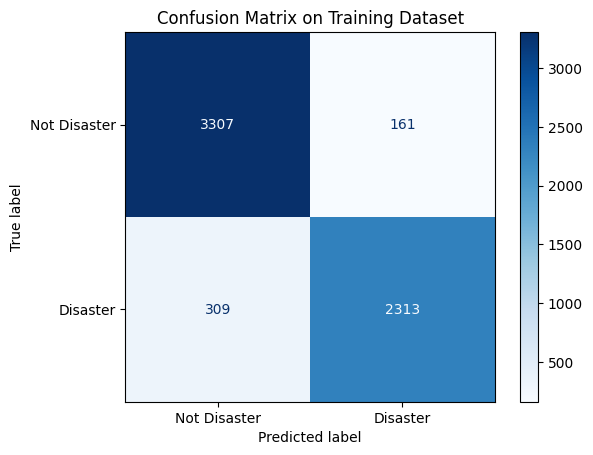

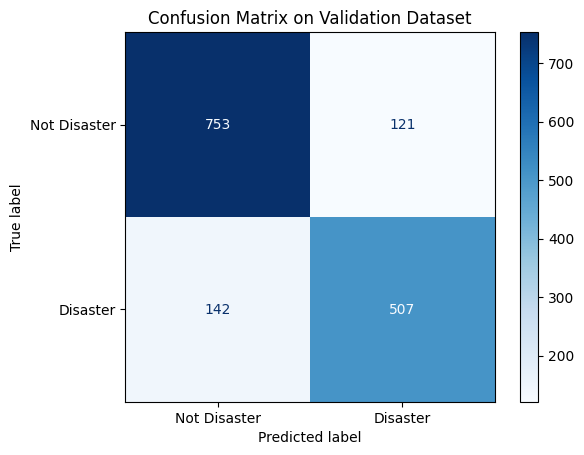

In [27]:
displayConfusionMatrix(y_train, np.argmax(train_predictions.predictions, axis=1), "Training")
displayConfusionMatrix(y_val, np.argmax(val_predictions.predictions, axis=1), "Validation")
